In [1]:
import numpy as np
import pandas as pd 
import category_encoders as ce 
import matplotlib.pyplot as plt 
import seaborn as sns 
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
train_df = pd.read_csv('../../data/data/train.csv')
val_df = pd.read_csv('../../data/data/validation.csv')
test_df = pd.read_csv('../../data/data/test.csv')

In [3]:
def cals_VIF(df):

    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values,i) for i in range(df.shape[1])]

    return vif

In [4]:
def value_to_color(n_colors, palette, color_min, color_max,val):
    val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
    ind = int(val_position * (n_colors - 1)) # target index in the color palette
    return palette[ind]

def hinton_plot(data, columns=[], corr_func='pearson'):
    if columns == []:
        corr = data.corr(method=corr_func)
    else:
        data = data.loc[:,columns]
        corr = data.corr(method=corr_func)

    corr = pd.melt(corr.reset_index(), id_vars='index')
    corr.columns = ['x','y','value']

    x = corr['x']
    y = corr['y']
    size = corr['value']

    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1)
    ax = plt.subplot(plot_grid[:,:-1])

    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)}

    size_scale = 500
    n_colors = 256
    palette = sns.diverging_palette(20, 220, n=n_colors) 
    color_min, color_max = [-1, 1]

    ax.scatter(
        x=x.map(x_to_num),
        y=y.map(y_to_num),
        s=size*size_scale,
        c=size.apply(lambda x: value_to_color(n_colors, palette, color_min, color_max, x)),
        marker='s'
    )

    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    ax.set_title("hintonmap for multi-colinearity between features")

    ax = plt.subplot(plot_grid[:,-1])

    col_x = [0]*len(palette)
    bar_y = np.linspace(color_min, color_max, n_colors)
    bar_height = bar_y[1] - bar_y[0]
    ax.barh(
        y=bar_y,
        width=[5]*len(palette), # Make bars 5 units wide
        left=col_x, # Make bars start at 0
        height=bar_height,
        color=palette,
        linewidth=0
    )

    ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
    ax.grid(False) # Hide grid
    ax.set_facecolor('white') # Make background white
    ax.set_xticks([]) # Remove horizontal ticks
    ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
    ax.yaxis.tick_right()

In [5]:
col_mask = ['Gender', 'Age', 'Ethnicity', 'Educational_Level',
       'Income', 'Country_region', 'Hotel_Type', 'Adults', 'Children', 'Babies',
       'Meal_Type', 'Visted_Previously', 'Previous_Cancellations',
       'Deposit_type', 'Booking_channel', 'Required_Car_Parking',
       'Use_Promotion', 'Discount_Rate', 'Room_Rate', 'Reservation_Status']

In [6]:
ms_train_df = train_df.loc[: , col_mask]
ms_val_df = val_df[col_mask]

In [7]:
cat_cols = ['Gender','Ethnicity', 'Educational_Level',
       'Income', 'Country_region', 'Hotel_Type','Meal_Type', 'Visted_Previously', 'Previous_Cancellations',
       'Deposit_type', 'Booking_channel', 'Required_Car_Parking', 'Use_Promotion', 'Discount_Rate']

In [8]:
def cat_to_int(df, columns, enc={}):
    df = df.copy()
    if enc == {} or len(columns) > len(enc) :
        maps = enc
        for col in columns:
            if col not in maps:
                mapping = {k: i for i,k in enumerate(df.loc[:,col].unique())}
                maps[col] = mapping
            df[col] = df[col].map(maps[col])
        return df, maps
    else:
        maps = enc
        for col in columns:
            df[col] = df[col].map(maps[col])
        return df

In [9]:
enc_train_df = cat_to_int(ms_train_df, ['Reservation_Status'], {'Reservation_Status' : {'Check-In' : 1, 'Canceled' : 2, 'No-Show': 3},})
enc_val_df = cat_to_int(ms_val_df, ['Reservation_Status'], {'Reservation_Status' : {'Check-In' : 1, 'Canceled' : 2, 'No-Show': 3},})
enc_train_df.head()

,Gender,Age,Ethnicity,Educational_Level,Income,Country_region,Hotel_Type,Adults,Children,Babies,Meal_Type,Visted_Previously,Previous_Cancellations,Deposit_type,Booking_channel,Required_Car_Parking,Use_Promotion,Discount_Rate,Room_Rate,Reservation_Status
0,F,40,Latino,Grad,<25K,North,City Hotel,2,2,0,BB,No,No,No Deposit,Online,Yes,Yes,10,218,1
1,F,49,Latino,Mid-School,50K -- 100K,East,City Hotel,3,3,0,BB,No,No,Refundable,Online,Yes,No,0,185,1
2,F,42,caucasian,Grad,<25K,East,City Hotel,3,3,0,BB,No,No,No Deposit,Online,Yes,No,0,119,1
3,M,25,African American,College,>100K,South,Airport Hotels,4,3,0,BB,No,No,Refundable,Agent,Yes,Yes,5,144,1
4,F,62,Latino,High-School,25K --50K,East,Resort,1,1,0,BB,No,No,No Deposit,Direct,No,Yes,10,242,1


In [10]:
cat_train_df, maps = cat_to_int(enc_train_df, cat_cols)

In [11]:
cat_train_df.head()

,Gender,Age,Ethnicity,Educational_Level,Income,Country_region,Hotel_Type,Adults,Children,Babies,Meal_Type,Visted_Previously,Previous_Cancellations,Deposit_type,Booking_channel,Required_Car_Parking,Use_Promotion,Discount_Rate,Room_Rate,Reservation_Status
0,0,40,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,0,218,1
1,0,49,0,1,1,1,0,3,3,0,0,0,0,1,0,0,1,1,185,1
2,0,42,1,0,0,1,0,3,3,0,0,0,0,0,0,0,1,1,119,1
3,1,25,2,2,2,2,1,4,3,0,0,0,0,1,1,0,0,2,144,1
4,0,62,0,3,3,1,2,1,1,0,0,0,0,0,2,1,0,0,242,1


ipykernel_launcher:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


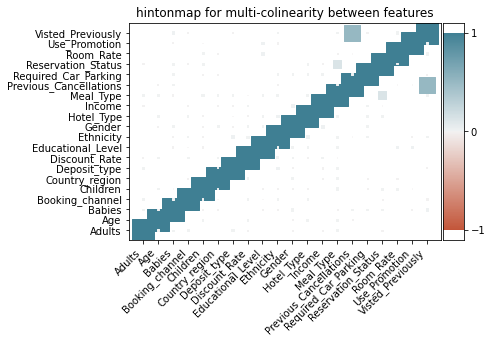

In [13]:
hinton_plot(cat_train_df, cat_train_df.columns.values)


In [14]:
cals_VIF(cat_train_df)

,variables,VIF
0,Gender,1.959958
1,Age,7.899365
2,Ethnicity,2.729316
3,Educational_Level,3.344980
4,Income,2.423520
5,Country_region,3.245801
6,Hotel_Type,2.437417
7,Adults,4.577981
8,Children,6.156177
9,Babies,1.368116


In [15]:
cat_encoder = ce.CatBoostEncoder(cols=cat_cols)
cat_train_ft = cat_encoder.fit_transform(enc_train_df[cat_cols], enc_train_df['Reservation_Status'])
#train_features = ms_train_df.join(woe_encoded_train)

f:\JetBrain Project Files\Pycharm\datastorm-2021\venv\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [16]:
cat_train_ft.head()

,Gender,Ethnicity,Educational_Level,Income,Country_region,Hotel_Type,Meal_Type,Visted_Previously,Previous_Cancellations,Deposit_type,Booking_channel,Required_Car_Parking,Use_Promotion,Discount_Rate
0,1.304884,1.304884,1.304884,1.304884,1.304884,1.304884,1.304884,1.304884,1.304884,1.304884,1.304884,1.304884,1.304884,1.304884
1,1.152442,1.152442,1.304884,1.304884,1.304884,1.152442,1.152442,1.152442,1.152442,1.304884,1.152442,1.152442,1.304884,1.304884
2,1.101628,1.304884,1.152442,1.152442,1.152442,1.101628,1.101628,1.101628,1.101628,1.152442,1.101628,1.101628,1.152442,1.152442
3,1.304884,1.304884,1.304884,1.304884,1.304884,1.304884,1.076221,1.076221,1.076221,1.152442,1.304884,1.076221,1.152442,1.304884
4,1.076221,1.101628,1.304884,1.304884,1.101628,1.304884,1.060977,1.060977,1.060977,1.101628,1.304884,1.304884,1.101628,1.152442


ipykernel_launcher:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


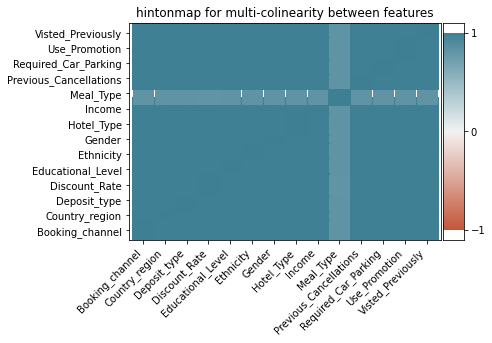

In [17]:
hinton_plot(cat_train_ft, cat_train_ft.columns.values)

In [24]:
cals_VIF(cat_train_ft)

,variables,VIF
0,Gender,227770.197061
1,Ethnicity,81044.429830
2,Educational_Level,81583.425833
3,Income,131500.142171
4,Country_region,63927.781673
5,Hotel_Type,55998.946607
6,Meal_Type,130.138525
7,Visted_Previously,55713.909249
8,Previous_Cancellations,121070.369960
9,Deposit_type,49622.867102


In [19]:
tag_encoder = ce.TargetEncoder(cols=cat_cols)
tag_train_ft = cat_encoder.fit_transform(enc_train_df[cat_cols], enc_train_df['Reservation_Status'])

f:\JetBrain Project Files\Pycharm\datastorm-2021\venv\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [20]:
tag_train_ft.head()

,Gender,Ethnicity,Educational_Level,Income,Country_region,Hotel_Type,Meal_Type,Visted_Previously,Previous_Cancellations,Deposit_type,Booking_channel,Required_Car_Parking,Use_Promotion,Discount_Rate
0,1.304884,1.304884,1.304884,1.304884,1.304884,1.304884,1.304884,1.304884,1.304884,1.304884,1.304884,1.304884,1.304884,1.304884
1,1.152442,1.152442,1.304884,1.304884,1.304884,1.152442,1.152442,1.152442,1.152442,1.304884,1.152442,1.152442,1.304884,1.304884
2,1.101628,1.304884,1.152442,1.152442,1.152442,1.101628,1.101628,1.101628,1.101628,1.152442,1.101628,1.101628,1.152442,1.152442
3,1.304884,1.304884,1.304884,1.304884,1.304884,1.304884,1.076221,1.076221,1.076221,1.152442,1.304884,1.076221,1.152442,1.304884
4,1.076221,1.101628,1.304884,1.304884,1.101628,1.304884,1.060977,1.060977,1.060977,1.101628,1.304884,1.304884,1.101628,1.152442


ipykernel_launcher:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


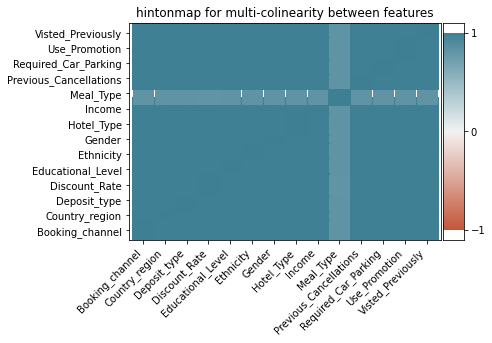

In [21]:
hinton_plot(tag_train_ft, tag_train_ft.columns.values)

In [23]:
cals_VIF(tag_train_ft)

,variables,VIF
0,Gender,227770.197061
1,Ethnicity,81044.429830
2,Educational_Level,81583.425833
3,Income,131500.142171
4,Country_region,63927.781673
5,Hotel_Type,55998.946607
6,Meal_Type,130.138525
7,Visted_Previously,55713.909249
8,Previous_Cancellations,121070.369960
9,Deposit_type,49622.867102


In [17]:
poly_enc = ce.PolynomialEncoder(cols=cat_cols)
poly_train_df = poly_enc.fit_transform(enc_train_df[cat_cols], enc_train_df['Reservation_Status'])

f:\JetBrain Project Files\Pycharm\datastorm-2021\venv\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [18]:
poly_train_df.head()

,intercept,Gender_0,Ethnicity_0,Ethnicity_1,Ethnicity_2,Educational_Level_0,Educational_Level_1,Educational_Level_2,Income_0,Income_1,...,Use_Promotion_0,Discount_Rate_0,Discount_Rate_1,Discount_Rate_2,Discount_Rate_3,Discount_Rate_4,Discount_Rate_5,Discount_Rate_6,Reservation_Status_0,Reservation_Status_1
0,1,-0.707107,-0.670820,0.5,-0.223607,-0.670820,0.5,-0.223607,-0.670820,0.5,...,-0.707107,-0.540062,0.540062,-0.430820,0.282038,-0.149786,0.061546,-0.017070,-0.707107,0.408248
1,1,-0.707107,-0.670820,0.5,-0.223607,-0.223607,-0.5,0.670820,-0.223607,-0.5,...,0.707107,-0.385758,0.077152,0.307729,-0.523785,0.492155,-0.307729,0.119488,-0.707107,0.408248
2,1,-0.707107,-0.223607,-0.5,0.670820,-0.670820,0.5,-0.223607,-0.670820,0.5,...,0.707107,-0.385758,0.077152,0.307729,-0.523785,0.492155,-0.307729,0.119488,-0.707107,0.408248
3,1,0.707107,0.223607,-0.5,-0.670820,0.223607,-0.5,-0.670820,0.223607,-0.5,...,-0.707107,-0.231455,-0.231455,0.430820,-0.120873,-0.363766,0.553912,-0.358464,-0.707107,0.408248
4,1,-0.707107,-0.670820,0.5,-0.223607,0.670820,0.5,0.223607,0.670820,0.5,...,-0.707107,-0.540062,0.540062,-0.430820,0.282038,-0.149786,0.061546,-0.017070,-0.707107,0.408248


In [20]:
print(poly_train_df.isnull().sum())
# hinton_plot(poly_train_df, poly_train_df.columns.values)

intercept                   0
Gender_0                    0
Ethnicity_0                 0
Ethnicity_1                 0
Ethnicity_2                 0
Educational_Level_0         0
Educational_Level_1         0
Educational_Level_2         0
Income_0                    0
Income_1                    0
Income_2                    0
Country_region_0            0
Country_region_1            0
Country_region_2            0
Hotel_Type_0                0
Hotel_Type_1                0
Meal_Type_0                 0
Meal_Type_1                 0
Visted_Previously_0         0
Previous_Cancellations_0    0
Deposit_type_0              0
Deposit_type_1              0
Booking_channel_0           0
Booking_channel_1           0
Required_Car_Parking_0      0
Use_Promotion_0             0
Discount_Rate_0             0
Discount_Rate_1             0
Discount_Rate_2             0
Discount_Rate_3             0
Discount_Rate_4             0
Discount_Rate_5             0
Discount_Rate_6             0
Reservatio

In [24]:
cnt_enc = ce.CountEncoder(cols=cat_cols)
cnt_train_df = cnt_enc.fit_transform(enc_train_df[cat_cols], enc_train_df['Reservation_Status'])

f:\JetBrain Project Files\Pycharm\datastorm-2021\venv\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [25]:
cnt_train_df.head()

,Gender,Ethnicity,Educational_Level,Income,Country_region,Hotel_Type,Meal_Type,Visted_Previously,Previous_Cancellations,Deposit_type,Booking_channel,Required_Car_Parking,Use_Promotion,Discount_Rate,Reservation_Status
0,13799,6806,5444,7739,5670,9134,14224,18344,24379,18244,15574,19629,20670,5469,21240
1,13799,6806,5481,7936,5460,9134,14224,18344,24379,6984,15574,19629,6829,6829,21240
2,13799,6890,5444,7739,5460,9134,14224,18344,24379,18244,15574,19629,6829,6829,21240
3,13700,6965,11052,3954,10917,9258,14224,18344,24379,6984,3983,19629,20670,4159,21240
4,13799,6806,5522,7870,5460,9107,14224,18344,24379,18244,7942,7870,20670,5469,21240


f:\JetBrain Project Files\Pycharm\datastorm-2021\venv\lib\site-packages\matplotlib\collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


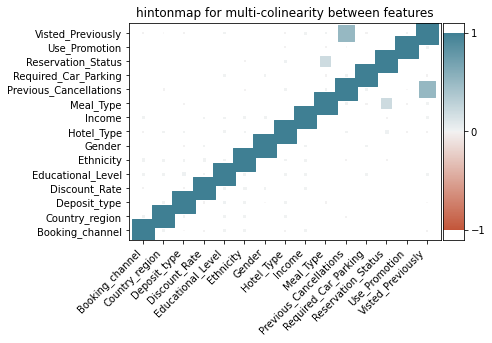

In [26]:
hinton_plot(cnt_train_df)

In [27]:
helm_enc = ce.HelmertEncoder(cols=cat_cols)
helm_train_df = helm_enc.fit_transform(enc_train_df[cat_cols], enc_train_df['Reservation_Status'])

f:\JetBrain Project Files\Pycharm\datastorm-2021\venv\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [28]:
helm_train_df.head()

,intercept,Gender_0,Ethnicity_0,Ethnicity_1,Ethnicity_2,Educational_Level_0,Educational_Level_1,Educational_Level_2,Income_0,Income_1,...,Use_Promotion_0,Discount_Rate_0,Discount_Rate_1,Discount_Rate_2,Discount_Rate_3,Discount_Rate_4,Discount_Rate_5,Discount_Rate_6,Reservation_Status_0,Reservation_Status_1
0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,1,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,...,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,1,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,1,1.0,0.0,2.0,-1.0,0.0,2.0,-1.0,0.0,2.0,...,-1.0,0.0,2.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,1,-1.0,-1.0,-1.0,-1.0,0.0,0.0,3.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [44]:
from category_encoders.wrapper import PolynomialWrapper
woe_enc = ce.WOEEncoder(cols=cat_cols)
wr_woe_enc = PolynomialWrapper(woe_enc)
wr_woe_enc.fit(enc_train_df[cat_cols], enc_train_df['Reservation_Status'])

#wr_train_df = wr_woe_enc.fit_transform(enc_train_df[cat_cols], enc_train_df['Reservation_Status'])

f:\JetBrain Project Files\Pycharm\datastorm-2021\venv\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
f:\JetBrain Project Files\Pycharm\datastorm-2021\venv\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [47]:
wr_woe_enc.transform(enc_train_df[cat_cols])
wr_train_df.head()

,Gender_2.0,Ethnicity_2.0,Educational_Level_2.0,Income_2.0,Country_region_2.0,Hotel_Type_2.0,Meal_Type_2.0,Visted_Previously_2.0,Previous_Cancellations_2.0,Deposit_type_2.0,...,Country_region_3.0,Hotel_Type_3.0,Meal_Type_3.0,Visted_Previously_3.0,Previous_Cancellations_3.0,Deposit_type_3.0,Booking_channel_3.0,Required_Car_Parking_3.0,Use_Promotion_3.0,Discount_Rate_3.0
0,0.020583,-0.006697,-0.010080,-0.007216,0.020583,-0.009372,-0.426113,0.008533,0.008481,0.006463,...,0.042098,0.014406,-0.462835,0.013048,-0.000893,0.037727,-0.000541,0.008392,0.006955,0.066954
1,0.020583,-0.006697,-0.041353,-0.029634,-0.022233,-0.009372,-0.426113,0.008533,0.008481,-0.010773,...,-0.011382,0.014406,-0.462835,0.013048,-0.000893,-0.127603,-0.000541,0.008392,-0.021300,-0.021300
2,0.020583,0.043132,-0.010080,-0.007216,-0.022233,-0.009372,-0.426113,0.008533,0.008481,0.006463,...,-0.011382,0.014406,-0.462835,0.013048,-0.000893,0.037727,-0.000541,0.008392,-0.021300,-0.021300
3,-0.021035,-0.056986,0.024333,0.050699,-0.000028,-0.053001,-0.426113,0.008533,0.008481,-0.010773,...,0.001997,-0.009330,-0.462835,0.013048,-0.000893,-0.127603,-0.050982,0.008392,0.006955,0.081982
4,0.020583,-0.006697,0.003228,0.012059,-0.022233,0.061525,-0.426113,0.008533,0.008481,0.006463,...,-0.011382,-0.003795,-0.462835,0.013048,-0.000893,0.037727,0.027266,-0.021191,0.006955,0.066954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27494,0.020583,-0.056986,-0.041353,-0.007216,0.002592,-0.009372,0.113970,-0.017252,-0.068033,0.006463,...,-0.033346,0.014406,0.176778,-0.026582,0.006954,0.037727,-0.000541,0.008392,0.006955,0.066954
27495,0.020583,0.020874,0.024333,0.012059,-0.000028,-0.053001,-0.426113,0.008533,0.008481,-0.010773,...,0.001997,-0.009330,-0.462835,0.013048,-0.000893,-0.127603,-0.050982,0.008392,0.006955,0.036744
27496,0.020583,-0.006697,0.003228,-0.029634,-0.000028,-0.053001,0.113970,0.008533,0.008481,0.006463,...,0.001997,-0.009330,0.176778,0.013048,-0.000893,0.037727,0.027266,0.008392,0.006955,0.081982
27497,-0.021035,-0.056986,0.024333,0.012059,-0.000028,-0.053001,0.659495,0.008533,0.008481,0.006463,...,0.001997,-0.009330,0.585802,0.013048,-0.000893,0.037727,-0.000541,-0.021191,0.006955,-0.069422


,Gender_2.0,Ethnicity_2.0,Educational_Level_2.0,Income_2.0,Country_region_2.0,Hotel_Type_2.0,Meal_Type_2.0,Visted_Previously_2.0,Previous_Cancellations_2.0,Deposit_type_2.0,...,Country_region_3.0,Hotel_Type_3.0,Meal_Type_3.0,Visted_Previously_3.0,Previous_Cancellations_3.0,Deposit_type_3.0,Booking_channel_3.0,Required_Car_Parking_3.0,Use_Promotion_3.0,Discount_Rate_3.0
0,0.020583,-0.006697,-0.010080,-0.007216,0.020583,-0.009372,-0.426113,0.008533,0.008481,0.006463,...,0.042098,0.014406,-0.462835,0.013048,-0.000893,0.037727,-0.000541,0.008392,0.006955,0.066954
1,0.020583,-0.006697,-0.041353,-0.029634,-0.022233,-0.009372,-0.426113,0.008533,0.008481,-0.010773,...,-0.011382,0.014406,-0.462835,0.013048,-0.000893,-0.127603,-0.000541,0.008392,-0.021300,-0.021300
2,0.020583,0.043132,-0.010080,-0.007216,-0.022233,-0.009372,-0.426113,0.008533,0.008481,0.006463,...,-0.011382,0.014406,-0.462835,0.013048,-0.000893,0.037727,-0.000541,0.008392,-0.021300,-0.021300
3,-0.021035,-0.056986,0.024333,0.050699,-0.000028,-0.053001,-0.426113,0.008533,0.008481,-0.010773,...,0.001997,-0.009330,-0.462835,0.013048,-0.000893,-0.127603,-0.050982,0.008392,0.006955,0.081982
4,0.020583,-0.006697,0.003228,0.012059,-0.022233,0.061525,-0.426113,0.008533,0.008481,0.006463,...,-0.011382,-0.003795,-0.462835,0.013048,-0.000893,0.037727,0.027266,-0.021191,0.006955,0.066954


In [24]:
df_2 = wr_train_df.iloc[:,:14]
df_3 = wr_train_df.iloc[:,14:]
df_2.columns = df_2.columns.str.rstrip('_2.0')
df_3.columns = df_3.columns.str.rstrip('_3.0')
avg_df = (df_2+df_3)/2

In [25]:
avg_df.head()

,Gender,Ethnicity,Educational_Level,Income,Country_region,Hotel_Type,Meal_Type,Visted_Previously,Previous_Cancellations,Deposit_type,Booking_channel,Required_Car_Parking,Use_Promotion,Discount_Rate
0,0.002971,0.010376,-0.001419,0.007453,0.031341,0.002517,-0.444474,0.010791,0.003794,0.022095,-0.000616,0.005952,0.004285,0.058951
1,0.002971,0.010376,0.006746,-0.012088,-0.016807,0.002517,-0.444474,0.010791,0.003794,-0.069188,-0.000616,0.005952,-0.013100,-0.013100
2,0.002971,-0.017315,-0.001419,0.007453,-0.016807,0.002517,-0.444474,0.010791,0.003794,0.022095,-0.000616,0.005952,-0.013100,-0.013100
3,-0.003235,0.014371,-0.003171,-0.012970,0.000985,-0.031166,-0.444474,0.010791,0.003794,-0.069188,-0.020869,0.005952,0.004285,0.014405
4,0.002971,0.010376,0.002616,0.012407,-0.016807,0.028865,-0.444474,0.010791,0.003794,0.022095,0.012327,-0.014993,0.004285,0.058951


In [12]:
def drop_suffix(self, prefix):
    self.columns = self.columns.str.rstrip(prefix)
    return self

In [33]:
not_cal_cols = [i for i in col_mask if i not in cat_cols]

In [34]:
fin_df = avg_df.join(enc_train_df.loc[:, not_cal_cols])

In [35]:
fin_df.head()

,Gender,Ethnicity,Educational_Level,Income,Country_region,Hotel_Type,Meal_Type,Visted_Previously,Previous_Cancellations,Deposit_type,Booking_channel,Required_Car_Parking,Use_Promotion,Discount_Rate,Age,Adults,Children,Babies,Room_Rate,Reservation_Status
0,0.002971,0.010376,-0.001419,0.007453,0.031341,0.002517,-0.444474,0.010791,0.003794,0.022095,-0.000616,0.005952,0.004285,0.058951,40,2,2,0,218,1
1,0.002971,0.010376,0.006746,-0.012088,-0.016807,0.002517,-0.444474,0.010791,0.003794,-0.069188,-0.000616,0.005952,-0.013100,-0.013100,49,3,3,0,185,1
2,0.002971,-0.017315,-0.001419,0.007453,-0.016807,0.002517,-0.444474,0.010791,0.003794,0.022095,-0.000616,0.005952,-0.013100,-0.013100,42,3,3,0,119,1
3,-0.003235,0.014371,-0.003171,-0.012970,0.000985,-0.031166,-0.444474,0.010791,0.003794,-0.069188,-0.020869,0.005952,0.004285,0.014405,25,4,3,0,144,1
4,0.002971,0.010376,0.002616,0.012407,-0.016807,0.028865,-0.444474,0.010791,0.003794,0.022095,0.012327,-0.014993,0.004285,0.058951,62,1,1,0,242,1


ipykernel_launcher:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
f:\JetBrain Project Files\Pycharm\datastorm-2021\venv\lib\site-packages\matplotlib\collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


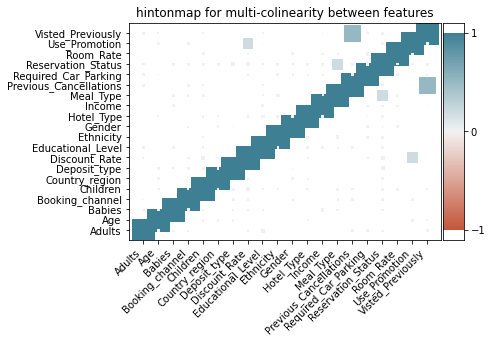

In [30]:
hinton_plot(fin_df, fin_df.columns.values)

In [46]:
wr_woe_enc.transform(enc_val_df)

ValueError: Unexpected input dimension 20, expected 14

In [36]:
cals_VIF(fin_df)

,variables,VIF
0,Gender,1.001809
1,Ethnicity,1.001539
2,Educational_Level,1.007145
3,Income,1.001199
4,Country_region,1.000990
5,Hotel_Type,1.000842
6,Meal_Type,1.059999
7,Visted_Previously,1.345777
8,Previous_Cancellations,1.345454
9,Deposit_type,1.001156


In [37]:
def corr_wt_target(df, target, columns):
    absCorr = []
    for col in columns:
        absCorr.append(abs(df[target].corr(df[col])))

    ax = sns.lineplot(columns,absCorr)
    ax.set_xticklabels(df.columns,rotation=45, horizontalalignment='right')
    ax.set_title("Absolute correlation of features with the target")

f:\JetBrain Project Files\Pycharm\datastorm-2021\venv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
ipykernel_launcher:7: UserWarning: FixedFormatter should only be used together with FixedLocator


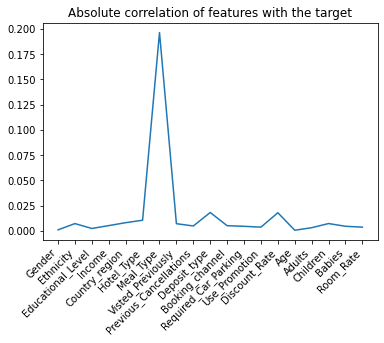

In [38]:
cl = fin_df.columns[:-1]
corr_wt_target(fin_df, 'Reservation_Status', cl)

In [39]:
from sklearn.decomposition import PCA

def pca_perc_var_plot(df):
    df = df.copy()
    pca = PCA(n_components=df.shape[1])
    pca_data = pca.fit_transform(df)

    percent_var_explained = pca.explained_variance_/(np.sum(pca.explained_variance_))
    cumm_var_explained = np.cumsum(percent_var_explained)
    plt.plot(cumm_var_explained, 'bo-')
    plt.grid()
    plt.title("percentage of variation explained")
    plt.xlabel("n_components")
    plt.ylabel("% variance explained")
    plt.show()

def pca_scree_plot(df):
    df = df.copy()
    pca = PCA(n_components=df.shape[1])
    pca_data = pca.fit_transform(df)

    pcs = np.arange(pca.n_components_)+1
    plt.plot(pcs, pca.explained_variance_ratio_, 'ro-', linewidth=2)
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Proportion of Variance Explained')
    plt.show()

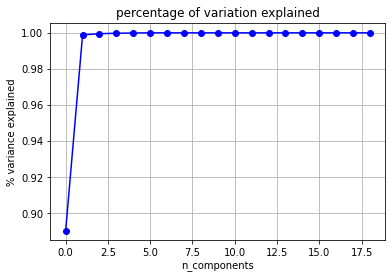

In [40]:
pca_perc_var_plot(fin_df.iloc[:, :-1])

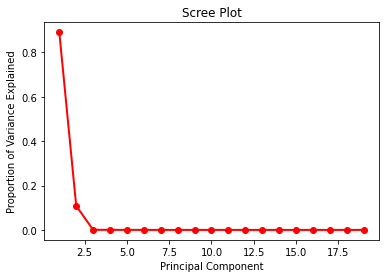

In [41]:
pca_scree_plot(fin_df.iloc[:, :-1])